Bayesian GPLVM with full rank covariance
--
This notebook shows the difference between a full rank and a diagonal variational distribution over the latent values.

In [66]:
import GPflow
from GPflow import ekernels
from GPflow import kernels
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
%matplotlib inline
import pods
pods.datasets.overide_manual_authorize = True  # dont ask to authorize
np.random.seed(42)
GPflow.settings.numerics.quadrature = 'error'  # throw error if quadrature is used for kernel expectations

### Data
Install the oil dataset.

In [67]:
data = pods.datasets.oil_100()
Y = data['X']
print('Number of points X Number of dimensions', Y.shape)
data['citation']

Number of points X Number of dimensions (100, 12)


'Bishop, C. M. and G. D. James (1993). Analysis of multiphase flows using dual-energy gamma densitometry and neural networks. Nuclear Instruments and Methods in Physics Research A327, 580-593'

### Model construction
Create Bayesian GPLVM model using additive kernel.

In [68]:
Q = 5
M = 20  # number of inducing pts
N = Y.shape[0]
X_mean = GPflow.gplvm.PCA_reduce(Y, Q) # Initialise via PCA
Z = np.random.permutation(X_mean.copy())[:M]
kerngen = lambda: ekernels.RBF(Q, ARD=True)

In [69]:
mdiag = GPflow.gplvm.BayesianGPLVM(X_mean=X_mean.copy(), X_std=0.1**0.5*np.ones((N, Q)), Y=Y,
                                kern=kerngen(), M=M, Z=Z.copy())
mdiag.likelihood.variance = 0.01
mdiag.optimize(disp=True, maxiter=100)

      fun: array([-57.2801721])
 hess_inv: <1107x1107 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.16850726,  0.53744901, -0.29338883, ...,  0.49398835,
       -0.12512715, -0.13992295])
  message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 107
      nit: 101
   status: 1
  success: False
        x: array([ 2.25226103,  8.11136978,  2.81063305, ...,  0.73406302,
        1.07450339,  0.11875083])

In [70]:
X_std_full = np.array([0.1**0.5*np.eye(Q) for _ in range(N)])
mfull = GPflow.gplvm.BayesianGPLVM(X_mean=X_mean.copy(), X_std=X_std_full, Y=Y,
                                kern=kerngen(), M=M, Z=Z.copy())
mfull.likelihood.variance = 0.01
mfull.optimize(disp=True, maxiter=100)

      fun: array([-312.45305878])
 hess_inv: <3107x3107 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.74112723, -0.01253389, -0.72889514, ..., -0.33198611,
       -1.24415955, -1.95717118])
  message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 105
      nit: 101
   status: 1
  success: False
        x: array([ -2.58324834,  -0.79248956,   1.68938853, ...,  12.29879794,
        13.66795438,   4.50235595])

In [71]:
print(mdiag.kern)

kern.variance transform:+ve prior:None
[ 2.35225322]
kern.lengthscales transform:+ve prior:None
[  8.11167084   2.86906039  10.7372996    8.31428762  20.75720742]


In [72]:
print(mfull.kern)

kern.lengthscales transform:+ve prior:None
[  9.31711294   3.31315665   9.28653332  12.29880349  13.66795654]
kern.variance transform:+ve prior:None
[ 4.51337884]


### Compute and sensitivity to input
Sensitivity is a measure of the importance of each latent dimension. 

[ 0.18907396  0.53456725  0.14283905  0.18446628  0.07388786]
[ 0.22801821  0.64122275  0.22876905  0.17273806  0.15543446]


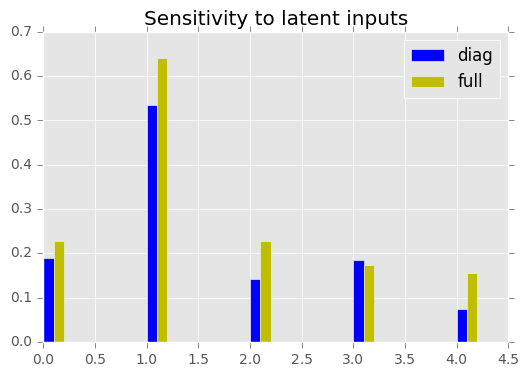

In [73]:
colours = ['b', 'y']
labels = ['diag', 'full']
inputIndices = list()
for i, m in enumerate([mdiag, mfull]):
    kern = m.kern
    sens = np.sqrt(kern.variance.value)/kern.lengthscales.value
    inputIndices.append(np.argsort(sens)[::-1][:2])
    print(sens)
    #fig, ax = plt.subplots()
    plt.bar(np.arange(len(kern.lengthscales.value)) + 0.1 * i , sens, 0.1, color=colours[i], label=labels[i])
    plt.legend()
    plt.title('Sensitivity to latent inputs')

In [74]:
inputIndices

[array([1, 0]), array([1, 2])]

### Plotting vs PCA
We see that using the 2 more relevant dimensions, the Bayesian GPLVM is able to seperate the
three classes while PCA cannot.

In [75]:
from sklearn import svm
from sklearn.metrics import accuracy_score
def linearSep(X, lbl):
    ''' function to compute linear separability '''
    return accuracy_score(lbl, svm.SVC(kernel='linear').fit(X, lbl).predict(X))
    

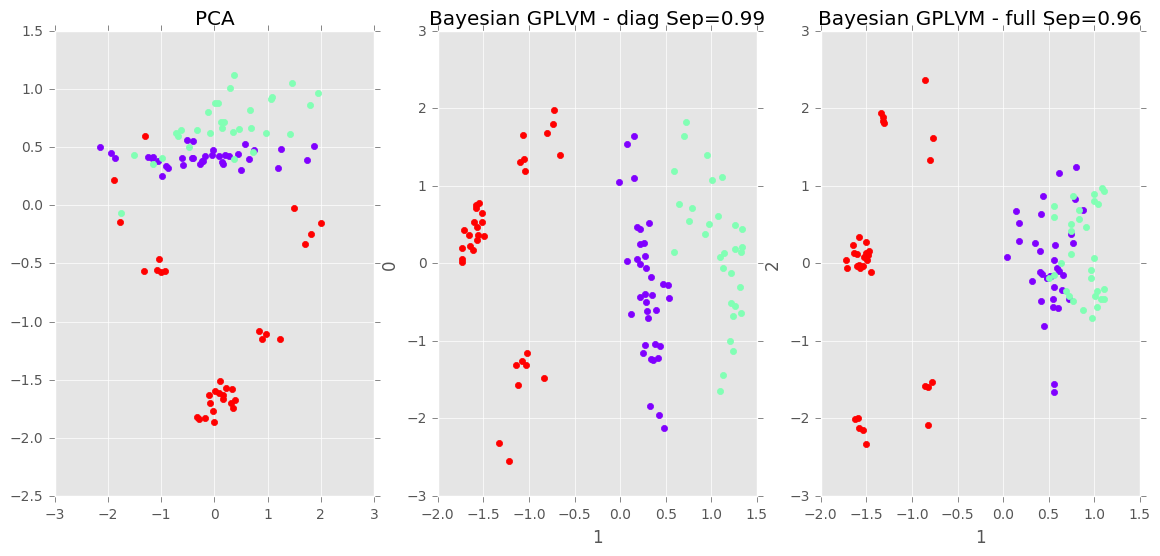

In [76]:
XPCAplot = GPflow.gplvm.PCA_reduce(data['X'], 2)
f, ax = plt.subplots(1,3, figsize=(14,6))
labels=data['Y'].argmax(axis=1)
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))

ax[0].set_title('PCA')
ax[1].set_xlabel(inputIndices[0][0]); ax[1].set_ylabel(inputIndices[0][1])
ax[1].set_title('Bayesian GPLVM - diag Sep=%.2f' % linearSep(mdiag.X_mean.value, labels))
ax[2].set_xlabel(inputIndices[1][0]); ax[2].set_ylabel(inputIndices[1][1])
ax[2].set_title('Bayesian GPLVM - full Sep=%.2f' % linearSep(mfull.X_mean.value, labels))
for i, c in zip(np.unique(labels), colors):
    ax[0].scatter(XPCAplot[labels==i,0], XPCAplot[labels==i,1], color=c, label=i)
    ax[1].scatter(mdiag.X_mean.value[labels==i,inputIndices[0][0]],
                  mdiag.X_mean.value[labels==i,inputIndices[0][1]], color=c, label=i)
    ax[2].scatter(mfull.X_mean.value[labels==i,inputIndices[1][0]], 
                  mfull.X_mean.value[labels==i,inputIndices[1][1]], color=c, label=i)